In [2]:
#import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import matplotlib as mpl
import skimage.feature
import skimage.color

#4s

In [3]:
#loading training data
df = pd.read_csv("/kaggle/input/images/data/train.csv")
image_names = np.array(df.iloc[:,0])
labels = np.array(df.iloc[:,1])
image_paths = "/kaggle/input/images/data/train_ims/" + image_names
images = []


for path in image_paths:
    image = cv2.imread(path)
    images.append(image)
print("data loaded")
#running time: 7m



data loaded


In [4]:
#loading test images
df_ = pd.read_csv("/kaggle/input/images/data/test.csv")
image_names_ = np.array(df_.iloc[:,0])

image_paths_ = "/kaggle/input/images/data/test_ims/" + image_names_

for path in image_paths_:
    image = cv2.imread(path)
    images.append(image)

In [5]:
#astype nparray
images = np.array(images)

In [6]:
images.shape

(60000, 32, 32, 3)

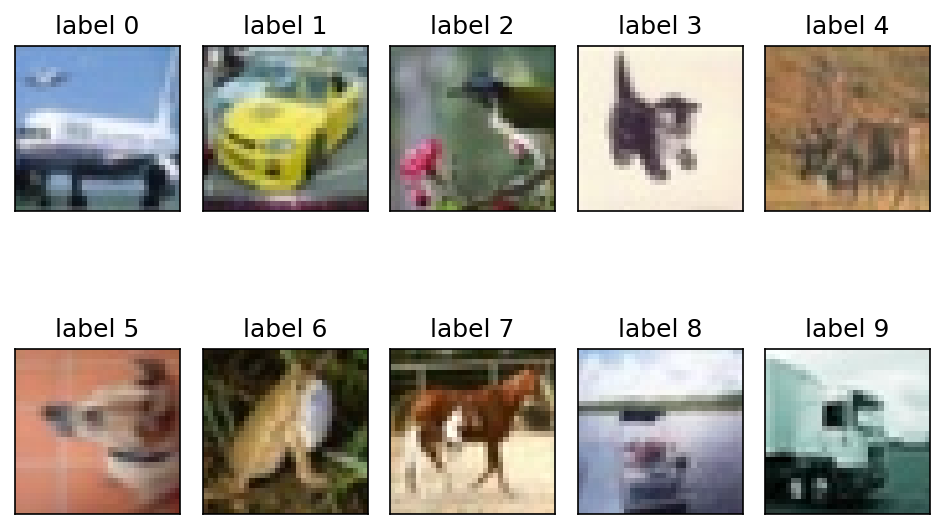

In [7]:
#visualize

def found():
    count = 10
    dic = np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
    for i in range(len(labels)):
        if dic[labels[i]] == -1:
            dic[labels[i]] = i
            count -= 1
        if count == 0:break
    return dic
def show_images(xs,dimx=32,dimy=32,channel=3):
    mpl.rcParams["figure.dpi"] = 150
    num_rows = 2
    num_cols = 5
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True)
    ax = ax.flatten()
    dic = found()
    xs_show = xs.reshape(60000,dimx,dimy,channel)
    for index in range(num_rows * num_cols):
        img = xs_show[dic[index]]
        label = labels[dic[index]]
        ax[index].imshow(img, cmap="Greys", interpolation="nearest")
        ax[index].set_title("label " + str(label))

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
show_images(images)

In [8]:
#statistic of the number of each class
for i in range(10):
    number = np.count_nonzero(labels == i)
    print(f"The number of images with label {i} is: ",number)

The number of images with label 0 is:  5038
The number of images with label 1 is:  5016
The number of images with label 2 is:  5032
The number of images with label 3 is:  4991
The number of images with label 4 is:  4982
The number of images with label 5 is:  4967
The number of images with label 6 is:  4985
The number of images with label 7 is:  4998
The number of images with label 8 is:  5002
The number of images with label 9 is:  4989


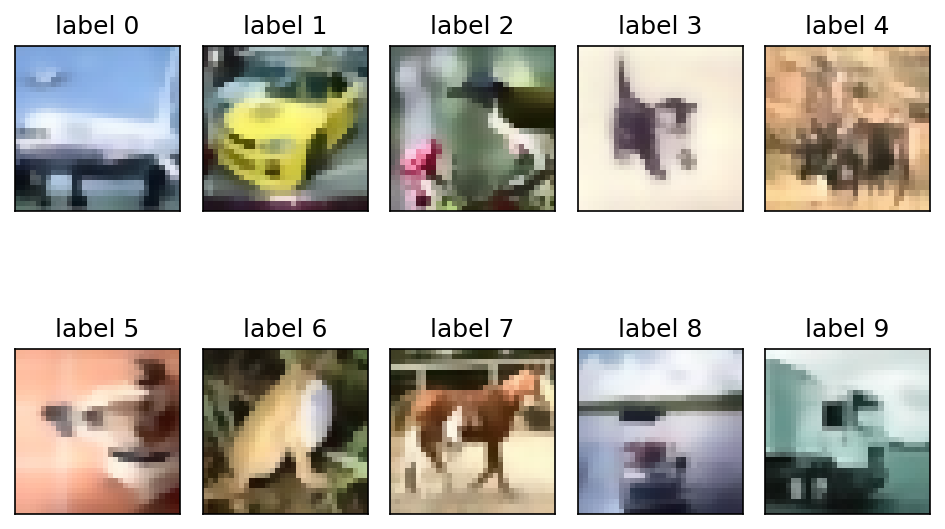

In [9]:
#enhence & normalization
def basic_preprocessing(images):
    processed = images.astype(np.float32) / 255.0
    processed_batch = np.zeros_like(processed)
    
    for i in range(images.shape[0]):
        img = images[i]
        
        # 对比度增强 
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
        lab[:, :, 0] = clahe.apply(lab[:, :, 0])  # 仅处理L通道
        enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        # 边缘保持滤波
        filtered = cv2.bilateralFilter(enhanced, d=5, sigmaColor=75, sigmaSpace=75)
        
        processed_batch[i] = filtered
    
    return processed_batch


images_train_processed = basic_preprocessing(images)

images_train_processed = images_train_processed.astype(int)
show_images(images_train_processed)
#running time: 20s

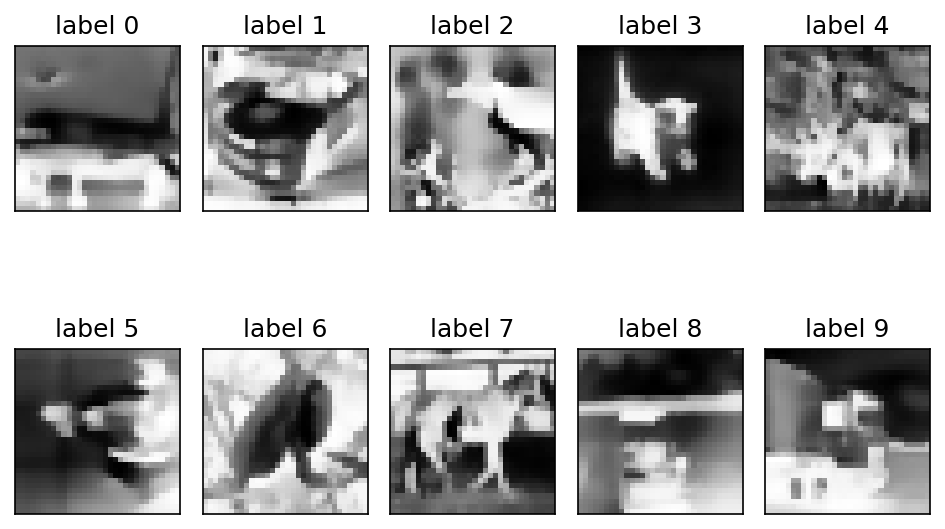

In [10]:
#rgb2gray
def rgb2gray(images):
    return np.dot(images[...,:3],[0.299, 0.587, 0.114])
images_gray = rgb2gray(images_train_processed)
show_images(images_gray,32,32,1)

In [79]:
#HOG & LBP features extract
from skimage.feature import hog,local_binary_pattern


def HOG(image):
    image_hog = hog(image=image,visualize=False, cells_per_block=(2,2),pixels_per_cell=(8,8),orientations=9)
    return image_hog
def LBP(img):
    img_blur = cv2.GaussianBlur(img, (3,3), 0)
    lbp_features = []
    gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    for R, P in zip([1,2,3], [8, 16, 24]):
        lbp = local_binary_pattern(gray, P=P, R=R, method='uniform')
        hist = np.histogram(lbp, bins=P+2, range=(0, P+2))[0]
        lbp_features.extend(hist / hist.sum())  # 归一化直方图
    return lbp_features
def HOG_batch(images):
    images_HOG = np.zeros((len(images), 324), dtype=np.float32)
    for i in range(len(images)):
        this_image = images[i]
        images_HOG[i] = HOG(this_image)
    return images_HOG
def LBP_batch(images):
    lbp_features = []
    for img in images:
        lbp_features.append(LBP(img))
    return np.array(lbp_features)
# images_HOG = HOG_batch(images_gray)
# images_LBP = LBP_batch(images_gray.astype(int)) #=>can not extract feature
#running time: 18s

In [12]:
#HSV features extract
from skimage.color import rgb2hsv
images_HSV = rgb2hsv(images_train_processed)
#running time 30s

/usr/local/lib/python3.11/dist-packages/skimage/color/colorconv.py:322: RuntimeWarning: divide by zero encountered in divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/usr/local/lib/python3.11/dist-packages/skimage/color/colorconv.py:326: RuntimeWarning: divide by zero encountered in divide
  out[idx, 0] = 2.0 + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/usr/local/lib/python3.11/dist-packages/skimage/color/colorconv.py:330: RuntimeWarning: divide by zero encountered in divide
  out[idx, 0] = 4.0 + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


In [ ]:
#sift features extract
import cv2
import numpy as np


def SIFT(gray_image):
    # 创建 SIFT 检测器
    sift = cv2.SIFT_create()

    # 检测关键点和计算描述符
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    # 绘制关键点
    output_image = cv2.drawKeypoints(gray_image, keypoints, None)

    # 显示结果
    cv2.imshow('SIFT Keypoints', output_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 假设 images_gray 是一个灰度图像数组
# SIFT(images_gray[0].astype(np.uint8))



def SIFT(img,nfeature):
    cat=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #2、sift关键点检测
    #sift实例化对象
    sift=cv2.SIFT_create(nfeatures = nfeature)

    # 2.2关键点检测：kp关键点信息包括方向，尺度，位置信息，des是关键点的描述符
    kp,des=sift.detectAndCompute(cat,None)
    return des
def SIFT_batch(images,nfeature):
    descriptors = []
    for i in range(len(images)):
        des = SIFT(images[i].astype(np.uint8),nfeature)
        if des is not None:
            descriptors.append(des[:nfeature,:])
        else:
            descriptors.append(np.zeros((nfeature,128)))
    return descriptors
# images_SIFT_descriptors_raw = SIFT_batch(images_train_processed,10)
#running time: 1m


In [15]:
#padding
def pad(arrays,dim):
    # 找到最大行数（x 的最大值）
    max_rows = max(arr.shape[0] for arr in arrays)

    # 创建一个填充后的数组，形状为 (len(arrays), max_rows, 128)
    padded_array = np.zeros((len(arrays), max_rows, dim))

    for i, arr in enumerate(arrays):
        # 将当前数组的内容填充到填充数组中
        padded_array[i, :arr.shape[0], :] = arr

    # 将数组转换为 (50000, 13, 128)
    return padded_array.transpose(0, 1, 2)  # 如果需要调整顺序可以使用 transpose




# images_SIFT_descriptors_padded = pad(images_SIFT_descriptors_raw)


In [16]:
#fast features extract
import os
import pickle
import cv2
import numpy as np

def FAST(train_data):

    # 尝试不同的特征检测算法
    def detect_features(image, method='FAST'):
        # 确保图像为uint8格式
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
        
        # 将图像转换为灰度图
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        if method == 'FAST':
            # 创建FAST检测器
            fast = cv2.FastFeatureDetector_create(threshold=10)
            keypoints = fast.detect(gray, None)
        else:
            raise ValueError("Unsupported method")
        
        return keypoints

    # 遍历训练集并检测特征点
    fast_keypoints_list = []  # 存储所有图像的FAST特征点

    for i in range(len(train_data)):
        image = train_data[i]
        # 确保图像为uint8格式
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
        
        # 检测FAST特征点
        keypoints = detect_features(image, method='FAST')
        
        # 如果没有检测到特征点，跳过
        if len(keypoints) == 0:
            print(f"Image {i} (Train): No keypoints detected")
            fast_keypoints_list.append(np.array([]))  # 存储空数组
            continue
        
        
        
        # 将关键点转换为numpy数组
        keypoints_array = np.array([(kp.pt[0], kp.pt[1], kp.size, kp.response) for kp in keypoints])
        fast_keypoints_list.append(keypoints_array)
        
        # 可视化检测到的特征点
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # image_with_keypoints = cv2.drawKeypoints(image_bgr, keypoints, None, color=(0, 255, 0))
        # cv2.imshow(f"Keypoints using FAST", image_with_keypoints)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

    # 将FAST特征点列表转换为numpy数组
    fast_keypoints_array = np.array(fast_keypoints_list, dtype=object)

    return fast_keypoints_array

In [469]:
#daisy features extract
import cv2
import numpy as np

def DAISY(images):
    daisy_features = []
    descriptor = cv2.xfeatures2d.DAISY_create()
    for img in images:
        # 将图像转换为灰度图
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # 计算 DAISY 特征
        keypoints = [cv2.KeyPoint(x, y, 10) for x in range(0, gray.shape[1], 10) for y in range(0, gray.shape[0], 10)]
        _, daisy_descriptors = descriptor.compute(gray, keypoints)  # 获取描述符
        # 将描述符展平并添加到特征列表中
        daisy_features.append(daisy_descriptors.flatten())
    return np.array(daisy_features)


In [ ]:
#generate features
images_processed = basic_preprocessing(images)
images_gray = rgb2gray(images_processed)
images_HOG = HOG_batch(images_gray)
images_HSV = rgb2hsv(images_processed)
images_FAST = pad(FAST(images_processed),4)
image_SIFT = pad(SIFT_batch(images_processed,3),128)
images_initiated = (images,images_processed,images_gray,images_HOG,images_HSV,image_SIFT,images_FAST)
images_lbp = LBP_batch(images_processed.astype(np.uint8))
images_daisy = DAISY(images_processed)

In [20]:
#pca for each single feature
from sklearn.decomposition import PCA
def doPCA(X,percentage = 0.95):
    pca = PCA(n_components=percentage)
    X_pca = pca.fit_transform(X)
    return X_pca

In [ ]:
#normalize & pca for each feature
from sklearn.preprocessing import StandardScaler, MinMaxScaler
"""hog+hsv+sift combined features"""
# images for different feature generating techniques
img_gray = images_initiated[2]
img_hog = images_initiated[3]
img_hsv = images_initiated[4]
img_sift = images_initiated[5]
img_fast = images_initiated[6]
img_lbp = images_lbp
img_daisy = images_daisy
# flatten those features respectively
X_hog = np.array([img.flatten() for img in img_hog])
X_hsv = np.array([img.flatten() for img in img_hsv])
X_sift = np.array([img.flatten() for img in img_sift])
X_gray = np.array([img.flatten() for img in img_gray])
X_fast = np.array([img.flatten() for img in img_fast])
X_lbp = np.array([img.flatten() for img in img_lbp])
X_daisy = np.array([img.flatten() for img in img_daisy])
# scaling respectively
scaler = StandardScaler()
X_hog_scaled = scaler.fit_transform(X_hog)
X_hsv_scaled = scaler.fit_transform(X_hsv)
X_sift_scaled = scaler.fit_transform(X_sift)
X_gray_scaled = scaler.fit_transform(X_gray)
X_fast_scaled = scaler.fit_transform(X_fast)
X_lbp_scaled = scaler.fit_transform(X_lbp)
X_daisy_scaled =scaler.fit_transform(X_daisy)





X_hog_scaled_pca = doPCA(X_hog_scaled,0.99)
X_hsv_scaled_pca = doPCA(X_hsv_scaled)
X_sift_scaled_pca = doPCA(X_sift_scaled)
X_gray_scaled_pca = doPCA(X_gray_scaled)
X_fast_scaled_pca = doPCA(X_fast_scaled)


X_lbp_scaled_pca = doPCA(X_lbp_scaled)
X_daisy_scaled_pca = doPCA(X_daisy_scaled)

In [428]:
#conbine selected feature into a single array
X_combined = np.hstack([X_hog_scaled_pca*2.5, X_hsv_scaled_pca,X_fast_scaled_pca,X_daisy_scaled_pca*1.5])

In [429]:
X_combined.shape

(60000, 955)

In [434]:
'''Train test split'''
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
y = labels
X_train, X_test, y_train, y_test = train_test_split(X_combined[:50000], y[:50000], test_size = 0.2, random_state = 42)

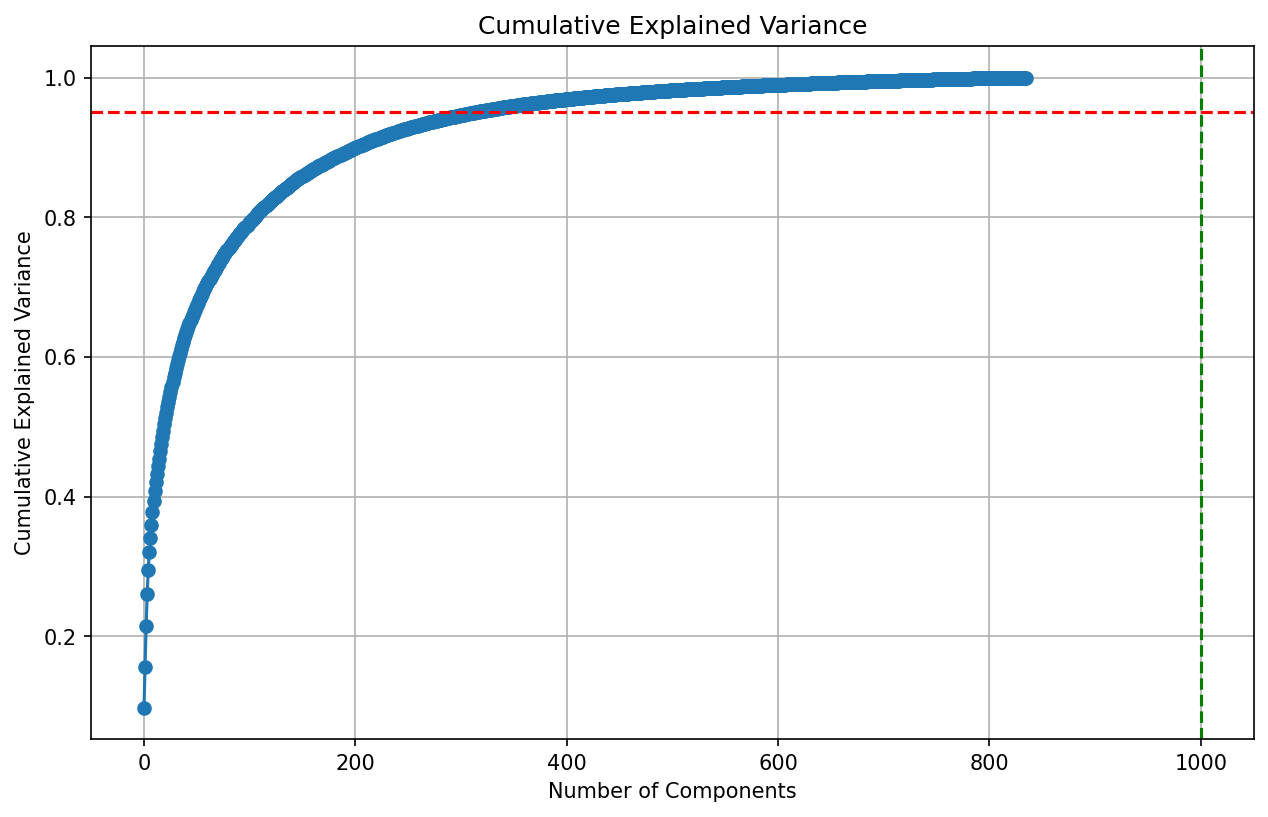

In [296]:
"""PCA for dimension reduction, choose suitable n-components by visualizing"""
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_combined[:50000])

# find the suitable n_components value
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=1000, color='g',linestyle='--') # x can be varied
plt.show()

In [443]:
"""PCA implementation"""
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
pritn(X_train_pca.shape)


In [446]:
"""SVM model"""
from cuml.svm import SVC  
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

# 确保数据为float32且连续
X_train_pca = np.ascontiguousarray(X_train_pca.astype(np.float32))
X_test_pca = np.ascontiguousarray(X_test_pca.astype(np.float32))


svm = SVC(cache_size = 100,verbose = True)
X_train_pca = X_train_pca.astype(np.float32)
param_grid = {
    'C':[100],
    'gamma': ['scale'],
    'kernel': ['rbf']
}
from sklearn.model_selection import RandomizedSearchCV
# 设置并行线程数
search = RandomizedSearchCV(estimator=svm, param_distributions=param_grid, 
                            n_iter=1, cv= 2,n_jobs=2,verbose = 20)
search.fit(X_train_pca, y_train)
best_svm = search.best_estimator_


svm_y_pred = best_svm.predict(X_test_pca)

svm_result = accuracy_score(y_test, svm_y_pred)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[2025-04-18 07:20:34.022] [CUML] [debug] Creating working set with 1024 elements
[2025-04-18 07:20:34.152] [CUML] [debug] SMO solver finished after 18 outer iterations, total inner 7155 iterations, and diff 0.000999
[2025-04-18 07:20:34.169] [CUML] [debug] Creating working set with 1024 elements
[2025-04-18 07:20:34.318] [CUML] [debug] SMO solver finished after 19 outer iterations, total inner 7640 iterations, and diff 0.000966
[2025-04-18 07:20:34.337] [CUML] [debug] Creating working set with 1024 elements
[2025-04-18 07:20:34.465] [CUML] [debug] SMO solver finished after 16 outer iterations, total inner 5847 iterations, and diff 0.001000
[2025-04-18 07:20:34.482] [CUML] [debug] Creating working set with 1024 elements
[2025-04-18 07:20:34.601] [CUML] [debug] SMO solver finished after 16 outer iterations, total inner 6272 iterations, and diff 0.000984
[2025-04-18 07:20:34.618] [CUML] [debug] Creating working set with 1024 eleme

In [447]:
svm_result


0.7096

In [448]:
search.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'C': 100}

In [454]:
#logistics regression model
from cuml import LogisticRegression

X_train_pca = np.ascontiguousarray(X_train_pca.astype(np.float32))
X_test_pca = np.ascontiguousarray(X_test_pca.astype(np.float32))

logis_reg = LogisticRegression()

logis_reg.fit(X_train_pca, y_train)
logis_y_pred = logis_reg.predict(X_test_pca)
logis_result = accuracy_score(y_test, logis_y_pred)

[2025-04-18 07:22:01.088] [CUML] [debug] CY::Estimator parameters:
[2025-04-18 07:22:01.089] [CUML] [debug] {'C': 1.0,
 '_full_kwargs': {},
 '_input_mem_type': None,
 '_input_type': None,
 '_verbose': 4,
 'class_weight': CumlArrayDescriptorMeta(input_type=None, values={None: None}),
 'fit_intercept': True,
 'handle': <pylibraft.common.handle.Handle object at 0x7b8b8775e1f0>,
 'l1_ratio': None,
 'linesearch_max_iter': 50,
 'max_iter': 1000,
 'n_features_in_': None,
 'output_mem_type': <MemoryType.device: 1>,
 'output_type': 'input',
 'penalty': 'l2',
 'solver': 'qn',
 'solver_model': QN(),
 'target_dtype': None,
 'tol': 0.0001,
 'verb_prefix': 'CY::'}
[2025-04-18 07:22:01.092] [CUML] [debug] CY::Setting loss to softmax
[2025-04-18 07:22:01.092] [CUML] [debug] CY::Calling QN fit softmax
[2025-04-18 07:22:01.655] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


In [455]:
logis_result

0.5866

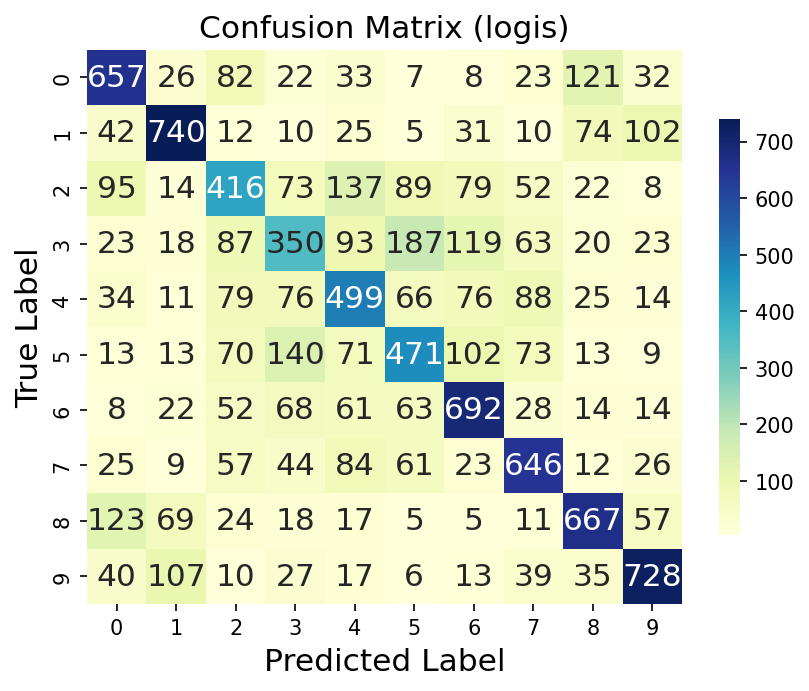

In [456]:
#confusion matrix for Logistic
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, logis_y_pred)

sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 15}, fmt='d', cmap='YlGnBu', cbar_kws={'shrink': 0.75})
plt.title('Confusion Matrix (logis)', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

plt.show()

precision_logis = np.diag(conf_matrix) / conf_matrix.sum(axis=0)

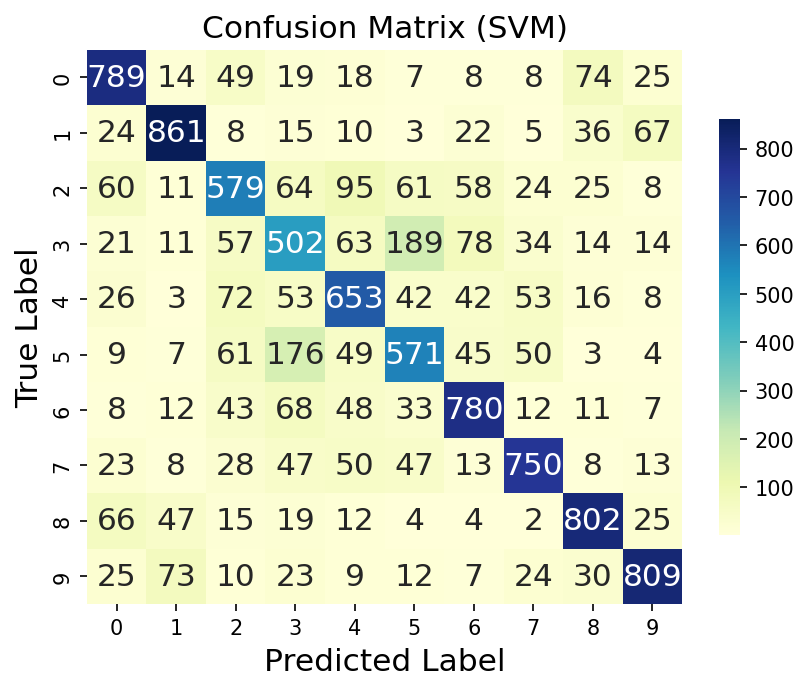

In [457]:
#confusion model for SVM
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, svm_y_pred)

sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 15}, fmt='d', cmap='YlGnBu', cbar_kws={'shrink': 0.75})
plt.title('Confusion Matrix (SVM)', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

plt.show()

precision_svm = np.diag(conf_matrix) / conf_matrix.sum(axis=0)

In [458]:
#use all dataset and same SVM model to predicct the test dataset
pca2 = PCA(n_components=0.95)
X_train_pca2 = pca2.fit_transform(X_combined[:50000])


In [460]:
"""SVM model"""
from cuml.svm import SVC  
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold

# 确保数据为float32且连续
X_train_pca2 = np.ascontiguousarray(X_train_pca2.astype(np.float32))



svm = SVC(cache_size = 100,verbose = True)
X_train_pca2 = X_train_pca2.astype(np.float32)
param_grid = {
    'C':[100],
    'gamma': ['scale'],
    'kernel': ['rbf']
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
from sklearn.model_selection import RandomizedSearchCV
# 设置并行线程数
search = RandomizedSearchCV(estimator=svm, param_distributions=param_grid, 
                            n_iter=10, cv=2, n_jobs=2,verbose = 20)
search.fit(X_train_pca2, labels)
best_svm = search.best_estimator_



Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/2; 1/1] START C=100, gamma=scale, kernel=rbf..............................
[2025-04-18 07:22:57.846] [CUML] [debug] Creating working set with 1024 elements
[2025-04-18 07:22:58.128] [CUML] [debug] SMO solver finished after 16 outer iterations, total inner 6401 iterations, and diff 0.000992
[2025-04-18 07:22:58.152] [CUML] [debug] Creating working set with 1024 elements
[2025-04-18 07:22:58.280] [CUML] [debug] SMO solver finished after 23 outer iterations, total inner 10835 iterations, and diff 0.000964
[2025-04-18 07:22:58.309] [CUML] [debug] Creating working set with 1024 elements
[2025-04-18 07:22:58.430] [CUML] [debug] SMO solver finished after 17 outer iterations, total inner 6747 iterations, and diff 0.000994
[2025-04-18 07:22:58.452] [CUML] [debug] Creating working set with 1024 elements
[2025-04-18 07:22:58.603] [CUML] [debug] SMO solver finished after 18 outer iterations, total inner 7207 iterations, and diff 0.000993
[2025-04-18 07:22:58.625] [CUML] [debug] Creating work

In [ ]:
X_exam_pca2 = pca2.transform(X_exam)

y_pre = best_svm.predict(X_exam_pca2)

In [463]:
#write the test.csv file
def write(y_pre):
    df = pd.read_csv("/kaggle/input/images/data/test.csv")
    df["label"] = y_pre
    df.to_csv('/kaggle/working/test.csv', index=False)

In [464]:
y_pre

array([3, 4, 0, ..., 1, 4, 2])

In [466]:
write(y_pre)